In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

df = pd.read_csv('telco_cleaned.csv')
print("Cleaned dataset shape:", df.shape)
print("Columns:", df.columns.tolist())

Cleaned dataset shape: (7021, 20)
Columns: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']


In [13]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

print("Categorical columns:", categorical_cols)
print("Numerical columns:", numerical_cols)

Categorical columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']
Numerical columns: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']


In [14]:
df['TotalServices'] = (df[['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                          'TechSupport', 'StreamingTV', 'StreamingMovies']] == 'Yes').sum(axis=1)

df['HasInternet'] = (df['InternetService'] != 'No').astype(int)

df['TenureGroup'] = pd.cut(df['tenure'], bins=[0, 12, 24, 48, 72],
                          labels=['0-1yr', '1-2yr', '2-4yr', '4-6yr'])

print("New features created: TotalServices, HasInternet, TenureGroup")

New features created: TotalServices, HasInternet, TenureGroup


In [15]:
categorical_to_encode = ['InternetService', 'Contract', 'PaymentMethod']

df_encoded = pd.get_dummies(df, columns=categorical_to_encode, prefix=categorical_to_encode)

print("Shape after one-hot encoding:", df_encoded.shape)

Shape after one-hot encoding: (7021, 30)


In [16]:
binary_columns = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']

label_encoder = LabelEncoder()

for col in binary_columns:
    if col in df_encoded.columns:
        df_encoded[col] = label_encoder.fit_transform(df_encoded[col])

print("Binary columns encoded:", binary_columns)

Binary columns encoded: ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']


In [17]:
service_columns = ['MultipleLines', 'OnlineSecurity', 'OnlineBackup',
                   'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

for col in service_columns:
    if col in df_encoded.columns:
        df_encoded[col] = df_encoded[col].map({'No': 0, 'Yes': 1, 'No phone service': 0, 'No internet service': 0})

print("Service columns converted to binary")

Service columns converted to binary


In [18]:
print("Final data types:")
print(df_encoded.dtypes.value_counts())

non_numeric = df_encoded.select_dtypes(include=['object']).columns
print("Non-numeric columns remaining:", len(non_numeric))

Final data types:
int64       17
bool        10
float64      2
category     1
Name: count, dtype: int64
Non-numeric columns remaining: 0


In [19]:
print("Final dataset shape:", df_encoded.shape)
print("First 5 rows of processed data:")
print(df_encoded.head())

Final dataset shape: (7021, 30)
First 5 rows of processed data:
   gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0       0              0        1           0       1             0   
1       1              0        0           0      34             1   
2       1              0        0           0       2             1   
3       1              0        0           0      45             0   
4       0              0        0           0       2             1   

   MultipleLines  OnlineSecurity  OnlineBackup  DeviceProtection  ...  \
0              0               0             1                 0  ...   
1              0               1             0                 1  ...   
2              0               1             1                 0  ...   
3              0               1             0                 1  ...   
4              0               0             0                 0  ...   

   InternetService_DSL  InternetService_Fiber optic  InternetService_N

In [20]:
df_encoded.to_csv('telco_processed.csv', index=False)
print("Processed dataset saved as 'telco_processed.csv'")

Processed dataset saved as 'telco_processed.csv'


Top 10 features by absolute correlation with Churn:
tenure: -0.352
HasInternet: 0.229
TotalCharges: -0.198
MonthlyCharges: 0.195
PaperlessBilling: 0.191
OnlineSecurity: -0.171
TechSupport: -0.164
Dependents: -0.163
SeniorCitizen: 0.152
Partner: -0.149


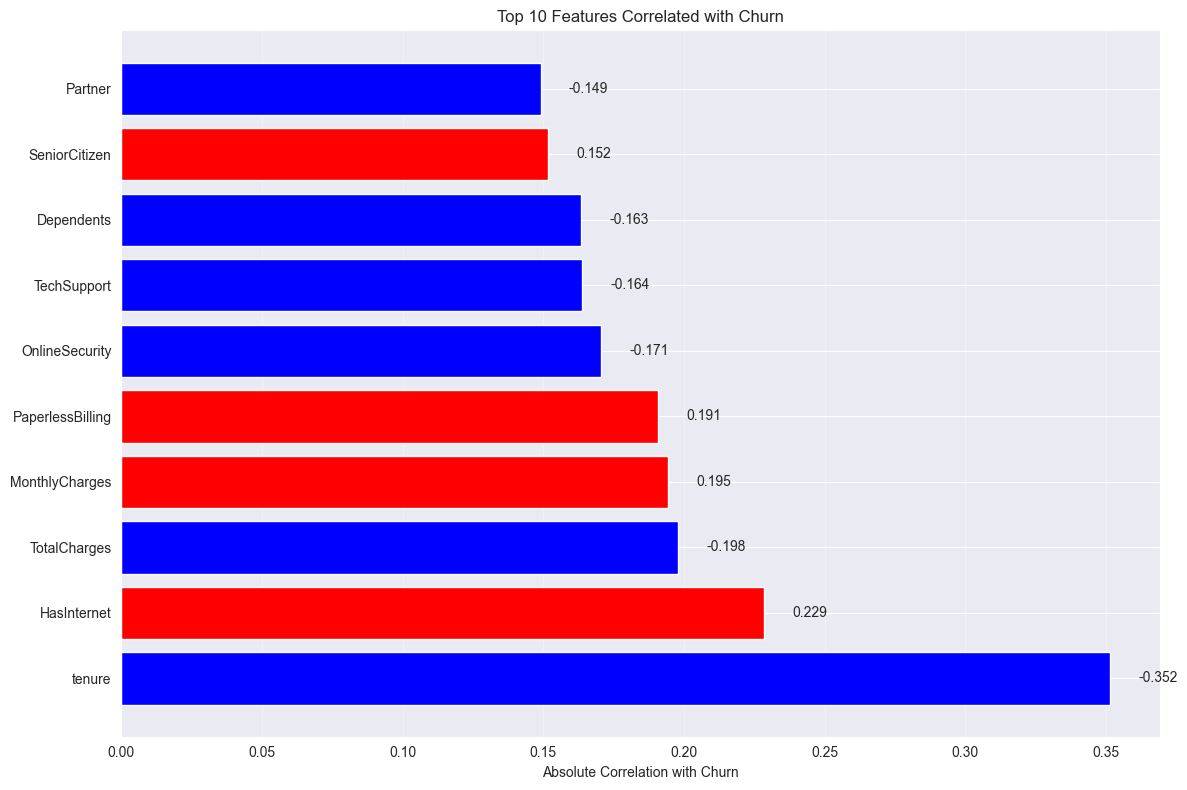

In [23]:
plt.figure(figsize=(12, 8))

numerical_cols_for_corr = df_encoded.select_dtypes(include=[np.number]).columns
numerical_df = df_encoded[numerical_cols_for_corr]

correlation_with_churn = numerical_df.corr()['Churn'].abs().sort_values(ascending=False)
top_features = correlation_with_churn.drop('Churn').head(10)

print("Top 10 features by absolute correlation with Churn:")
for feature, corr in top_features.items():
    actual_corr = numerical_df.corr()['Churn'][feature]
    print(f"{feature}: {actual_corr:.3f}")

colors = ['red' if numerical_df.corr()['Churn'][feature] > 0 else 'blue' for feature in top_features.index]

plt.barh(range(len(top_features)), top_features.values, color=colors)
plt.yticks(range(len(top_features)), top_features.index)
plt.title('Top 10 Features Correlated with Churn')
plt.xlabel('Absolute Correlation with Churn')
plt.grid(axis='x', alpha=0.3)

for i, (feature, corr) in enumerate(zip(top_features.index, top_features.values)):
    actual_corr = numerical_df.corr()['Churn'][feature]
    plt.text(corr + 0.01, i, f'{actual_corr:.3f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()